# Libraries

In [1]:
import ee
import folium
from folium import plugins
from google.colab import drive
import matplotlib.pyplot as plt
import os
import pandas as pd

# Inputs

In [2]:
intervention_ee_path = 'users/balakumaranrm/WASSAN/Wassan_AP_TL'
prefix = 'WASSAN'
constraint = 'village' # village or subdistrict
buffer_distance = 5000  # in meters for village constraint
start_year = 2018
end_year = 2022
ee_project_id = 'ee-balakumaranrm'
export2drive = False # True or False

In [3]:
# don't change these values
shrug_folder = 'users/jaltolwelllabs/SHRUG'
IndiaSAT_ee_path = 'users/jaltolwelllabs/LULC/IndiaSAT_V2_draft'
rain_ee_path = 'users/jaltolwelllabs/IMD/rain'
S2_ee_path = "COPERNICUS/S2_SR_HARMONIZED"
state_field = 'state_name'
district_field = 'district_n'
subdistrict_field = 'subdistric'
village_field = 'village_na'
unique_field = 'unique_name'

# Setup

In [4]:
if export2drive:
  drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/'

In [5]:
try:
  ee.Initialize(project=ee_project_id)
except:
  ee.Authenticate()
  ee.Initialize(project=ee_project_id)

In [6]:
intervention_collection = ee.FeatureCollection(intervention_ee_path)
intervention_count = intervention_collection.size().getInfo()
if intervention_count == 0:
  raise AttributeError('The Intervention Asset provided has 0 Features')

IndiaSAT = ee.ImageCollection(IndiaSAT_ee_path)
srtm = ee.Image('USGS/SRTMGL1_003').select('elevation')
srtm_slope = ee.Terrain.slope(srtm)
imd_rain = ee.ImageCollection(rain_ee_path)
S2 = ee.ImageCollection(S2_ee_path)

In [7]:
assets = ee.data.listAssets(shrug_folder)
feature_collections = []
for asset in assets['assets']:
    # Check if the asset is a FeatureCollection or TABLE
    if asset['type'] in {'FeatureCollection', 'TABLE'}:
        # Get the asset ID
        asset_id = asset['id']
        # Load the FeatureCollection and append it to the list
        feature_collection = ee.FeatureCollection(asset_id)
        feature_collections.append(feature_collection)

# Merge all the FeatureCollections into a single variable
village_fc = ee.FeatureCollection(feature_collections).flatten()

In [8]:
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [9]:
def add_ee_layer(self, ee_object, vis_params, name):

    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except:
        print("Could not display {}".format(name))

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [10]:
# my_map = folium.Map(location=[40.33, -99.42], zoom_start=4, height=500)
# basemaps['Google Satellite'].add_to(my_map)
# geometry = ee.FeatureCollection(f'users/balakumaran247/swSentinel/SOI_States').first().geometry()
# my_map.add_ee_layer(geometry, {}, 'Polygon')
# my_map.add_child(folium.LayerControl())
# plugins.Fullscreen().add_to(my_map)
# display(my_map)

# Processing

## Similar Villages

In [11]:
def gen_unique_village(feat):
  return feat.set(unique_field,
           ee.String(feat.get(village_field)).cat(
               ee.String('_')).cat(ee.String(feat.get(subdistrict_field))).cat(
                   ee.String('_')).cat(ee.String(feat.get(district_field))).cat(
                       ee.String('_')).cat(ee.String(feat.get(state_field))))
def gen_unique_subdistrict(feat):
  return feat.set(unique_field,
           ee.String(feat.get(subdistrict_field)).cat(
                   ee.String('_')).cat(ee.String(feat.get(district_field))).cat(
                       ee.String('_')).cat(ee.String(feat.get(state_field))))

In [12]:
def compute_centroid(feature):
    return feature.centroid().geometry()
def get_buffer(feature):
    return feature.geometry().buffer(buffer_distance)
def compute_slope(feature):
    std_dev = srtm_slope.reduceRegion(
        reducer=ee.Reducer.stdDev(),
        geometry=feature.geometry(),
        scale=30
        )
    return feature.set('slope_std_dev', std_dev.getNumber('slope'))
def compute_area(feature):
    area = feature.geometry().area()
    return feature.set('area', area)

In [13]:
def combine_subdistrict_villages(subdistrict_name):
  return ee.Feature(village_fc.filter(ee.Filter.Or(
      ee.Filter.inList(state_field, intervention_state_list),
      ee.Filter.inList(district_field, intervention_district_list)
    )).filter(ee.Filter.eq(subdistrict_field, subdistrict_name)).union().first()).set(
        subdistrict_field, subdistrict_name
    )

In [14]:
def feature2point(feature):
  return feature.centroid().set(
      subdistrict_field, feature.get(subdistrict_field)
  )

In [15]:
# Find the centroids of features from intervention
centroids_fc = intervention_collection.map(compute_centroid)
# Filter features from SHRUG that intersect with centroids
intervention_shrug = village_fc.filterBounds(centroids_fc)
intervention = intervention_shrug.map(gen_unique_village)

In [16]:
intervention_state_list = intervention.distinct(state_field).aggregate_array(state_field)
intervention_district_list = intervention.distinct(district_field).aggregate_array(district_field)
intervention_subdistrict_list = intervention.distinct(subdistrict_field).aggregate_array(subdistrict_field)
# intervention_subdistrict_fc = village_fc.filter(ee.Filter.Or(
#     ee.Filter.inList(state_field, intervention_state_list),
#     ee.Filter.inList(district_field, intervention_district_list),
#     ee.Filter.inList(subdistrict_field, intervention_subdistrict_list)
# ))
intervention_subdistrict_fc = ee.FeatureCollection(intervention_subdistrict_list.map(combine_subdistrict_villages))
potential_control_filter = ee.Filter.intersects(leftField='.geo', rightValue=intervention_subdistrict_fc.geometry()).Not()
potential_control_subdistrict_list = village_fc.filter(ee.Filter.Or(
    ee.Filter.inList(state_field, intervention_state_list),
    ee.Filter.inList(district_field, intervention_district_list)
)).filter(potential_control_filter).distinct(subdistrict_field).aggregate_array(subdistrict_field)
potential_control_subdistrict_fc = ee.FeatureCollection(potential_control_subdistrict_list.map(combine_subdistrict_villages))
potential_control_subdistrict_points = potential_control_subdistrict_fc.map(feature2point)

In [17]:
def compare_village(village):
  intervention_slope = compute_slope(village)
  spatial_filter = ee.Filter.intersects(leftField='.geo', rightValue=compute_centroid(village)).Not()
  null_filter = ee.Filter.eq(village_field, '').Not()
  buffer_fc = village_fc.filterBounds(get_buffer(village)).filter(spatial_filter).filter(null_filter).map(gen_unique_village).map(compute_slope)
  value_to_subtract = ee.Number(intervention_slope.get('slope_std_dev'))
  def subtract_value(feature):
    property_value = ee.Number(feature.get('slope_std_dev'))
    new_property_value = ee.Number(((property_value.subtract(value_to_subtract)).divide(value_to_subtract)).multiply(100)).abs()
    return feature.set('slope_diff', new_property_value)
  selected_village = buffer_fc.map(subtract_value).sort('slope_diff').first()
  return village.set(
          'intersect', selected_village.get(unique_field)
      ).set(
          'slope_std_dev', value_to_subtract
      ).set(
          'intersect_slope', selected_village.get('slope_std_dev')
      ).set(
          'intersect_slope_diff', selected_village.get('slope_diff')
      )

In [18]:
def compare_subdistrict(village):
  intervention_slope = compute_slope(village)
  # intervention_fc = village_fc.filter(ee.Filter.And(
  #     ee.Filter.eq(state_field, village.get(state_field)),
  #     ee.Filter.eq(district_field, village.get(district_field)),
  #     ee.Filter.eq(subdistrict_field, village.get(subdistrict_field))
  #     ))
  # spatial_filter = ee.Filter.intersects(leftField='.geo', rightValue=intervention_subdistrict_fc.geometry()).Not()
  null_filter = ee.Filter.eq(village_field, '').Not()
  # buffer_selected = village_fc.filterBounds(get_buffer(intervention_fc)).filter(spatial_filter)
  # buffer_state_list = buffer_selected.distinct(state_field).aggregate_array(state_field)
  # buffer_subdistrict_list = buffer_selected.distinct(subdistrict_field).aggregate_array(subdistrict_field)
  # buffer_fc = village_fc.filter(ee.Filter.Or(
  #   ee.Filter.inList(state_field, buffer_state_list),
  #   ee.Filter.inList(subdistrict_field, buffer_subdistrict_list)
  #   )).filter(null_filter).map(gen_unique_village).map(compute_slope)
  def compute_distance(feat):
    dist = feat.geometry().distance(village.centroid().geometry())
    return feat.set('distance', dist)
  nearest_subdistrict_centroid = potential_control_subdistrict_points.map(compute_distance).sort('distance').first()
  selected_subdistrict_fc = village_fc.filter(ee.Filter.And(
      ee.Filter.eq(state_field, village.get(state_field)),
      ee.Filter.eq(subdistrict_field, nearest_subdistrict_centroid.get(subdistrict_field))
      )).filter(null_filter).map(gen_unique_village).map(compute_slope)
  value_to_subtract = ee.Number(intervention_slope.get('slope_std_dev'))
  def subtract_value(feature):
    property_value = ee.Number(feature.get('slope_std_dev'))
    new_property_value = ee.Number(((property_value.subtract(value_to_subtract)).divide(value_to_subtract)).multiply(100)).abs()
    return feature.set('slope_diff', new_property_value)
  # selected_village = buffer_fc.map(subtract_value).sort('slope_diff').first()
  selected_village = selected_subdistrict_fc.map(subtract_value).sort('slope_diff').first()
  return village.set(
          'intersect', selected_village.get(unique_field)
      ).set(
          'slope_std_dev', value_to_subtract
      ).set(
          'intersect_slope', selected_village.get('slope_std_dev')
      ).set(
          'intersect_slope_diff', selected_village.get('slope_diff')
      )

In [19]:
if constraint == 'village':
  I_compared = intervention.map(compare_village)
elif constraint == 'subdistrict':
  I_compared = intervention.map(compare_subdistrict)
else:
  raise ValueError('Given constraint is not applicable')

In [20]:
stats = I_compared.getInfo()

In [21]:
I_C_out_dict = {}
for ix, feat in enumerate(stats['features']):
    props = feat['properties']
    I_C_out_dict[ix] = {'Intervention': props[unique_field], 'Control': props['intersect']}

In [22]:
I_C_df = pd.DataFrame(I_C_out_dict).T

In [23]:
I_C_raw_dict = {}

In [24]:
I_C_state_set = set()
I_C_district_set = set()
I_C_subdistrict_set = set()
I_C_village_set = set()

In [25]:
for ix, IC_value in I_C_out_dict.items():
  I_key = IC_value['Intervention']
  C_key = IC_value['Control']
  I_C_raw_dict[I_key] = {}
  I_C_raw_dict[C_key] = {}
  I_village, I_subdistrict, I_district, I_state = I_key.split('_')
  C_village, C_subdistrict, C_district, C_state = C_key.split('_')
  I_C_state_set.update([I_state, C_state])
  I_C_district_set.update([I_district, C_district])
  I_C_subdistrict_set.update([I_subdistrict, C_subdistrict])
  I_C_village_set.update([I_village, C_village])
  I_C_raw_dict[I_key]['state'] = I_state
  I_C_raw_dict[I_key]['district'] = I_district
  I_C_raw_dict[I_key]['subdistrict'] = I_subdistrict
  I_C_raw_dict[I_key]['village'] = I_village
  I_C_raw_dict[C_key]['state'] = C_state
  I_C_raw_dict[C_key]['district'] = C_district
  I_C_raw_dict[C_key]['subdistrict'] = C_subdistrict
  I_C_raw_dict[C_key]['village'] = C_village
  I_C_raw_dict[I_key]['type'] = f'Intervention_{ix}'
  I_C_raw_dict[C_key]['type'] = f'Control_{ix}'

In [26]:
if "" in I_C_village_set: raise AttributeError('Village with Null present')

In [27]:
I_C_fc = village_fc.filter(ee.Filter.And(
    ee.Filter.inList(state_field, list(I_C_state_set)),
    ee.Filter.inList(district_field, list(I_C_district_set)),
    ee.Filter.inList(subdistrict_field, list(I_C_subdistrict_set)),
    ee.Filter.inList(village_field, list(I_C_village_set))
    )).map(gen_unique_village).map(compute_area)

In [28]:
area_stats = I_C_fc.getInfo()

In [29]:
for feat in area_stats['features']:
    props = feat['properties']
    name = props[unique_field]
    if name in I_C_raw_dict.keys():
      I_C_raw_dict[name]['area_m2'] = props['area']

## Access Indicator

In [30]:
def area_image(image):
    return image.multiply(ee.Image.pixelArea())

def get_stats(image, roi):
    stat = image.reduceRegions(
        collection=roi,
        reducer=ee.Reducer.sum(),
        scale=10,
        crs='EPSG:4326',
    )
    return stat.getInfo()

def aggregate_dict(stat, unique_field):
    if isinstance(unique_field,str):
        unique_field = (unique_field,)
    return {
        '_'.join(tuple(feat['properties'][field] for field in unique_field)) : feat['properties']['sum']
        for feat in stat['features']
    }

In [31]:
def access_indicator_IndiaSAT(year, fc, unique_field):
    image = IndiaSAT.filterDate(f'{year}-07-01', f'{year+1}-06-30').filterBounds(fc.geometry()).mosaic().select(['b1'])
    irrig_image = area_image(image.updateMask(image.gte(10).And(image.lte(11))))
    crop_image = area_image(image.updateMask(image.gte(8).And(image.lte(11))))

    irrig_stat = aggregate_dict(get_stats(irrig_image, fc), unique_field)
    crop_stat = aggregate_dict(get_stats(crop_image, fc), unique_field)
    access_scores = {key: -999.0 if crop_stat[key]==0 else irrig_stat[key]/crop_stat[key] for key in irrig_stat.keys()}
    return access_scores, crop_stat, irrig_stat

In [32]:
for year in range(start_year, end_year+1):
    access_scores, crop_area, irrig_area = access_indicator_IndiaSAT(year, I_C_fc, unique_field)
    for name, access_value in access_scores.items():
      if name in I_C_raw_dict.keys():
        I_C_raw_dict[name][year] = access_value
    for name, area_value in irrig_area.items():
      if name in I_C_raw_dict.keys():
        I_C_raw_dict[name][f'{year}_double_m2'] = area_value
    for name, area_value in crop_area.items():
      if name in I_C_raw_dict.keys():
        I_C_raw_dict[name][f'{year}_single_m2'] = area_value - irrig_area[name]

## Rainfall

In [33]:
def compute_rain(year, fc):
  image = imd_rain.filterDate(f'{year}-07-01', f'{year+1}-07-01').sum()
  return image.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.mean(),
        scale=100,
        crs='EPSG:4326',
      ).getInfo()

In [34]:
for year in range(start_year, end_year+1):
    rain_stat = compute_rain(year, I_C_fc)
    for feat in rain_stat['features']:
      props = feat['properties']
      name = props[unique_field]
      if name in I_C_raw_dict.keys():
        I_C_raw_dict[name][f'{year}_rain'] = props['mean']

## Final

In [35]:
raw_df = pd.DataFrame(I_C_raw_dict).T
column_arrange = ['state','district','subdistrict','village','type']
for year in range(start_year, end_year+1):
  column_arrange.append(year)
for year in range(start_year, end_year+1):
  column_arrange.append(f'{year}_rain')
column_arrange.append('area_m2')
for year in range(start_year, end_year+1):
  column_arrange.append(f'{year}_single_m2')
  column_arrange.append(f'{year}_double_m2')
raw_df = raw_df[column_arrange]

In [36]:
diff_dict = {}
for ix, row in I_C_df.iterrows():
  row_intervention = row['Intervention']
  row_control = row['Control']
  diff_dict[ix] = {
      'Intervention' : row_intervention,
      'Control' : row_control,
  }
  for year in range(start_year, end_year+1):
    diff_dict[ix][year] = raw_df.loc[row_intervention][year] - raw_df.loc[row_control][year]

In [37]:
diff_df = pd.DataFrame(diff_dict).T

## Print

In [38]:
I_C_df.head()

,Intervention,Control
0,chintakarra_utnoor_adilabad_andhra pradesh,maregaon_adilabad_adilabad_andhra pradesh
1,kohinur buzurg_sirpur_adilabad_andhra pradesh,bhurnur_sirpur_adilabad_andhra pradesh
2,nagireddipalle_rayadurg_anantapur_andhra pradesh,bhupasamudram_gummagatta_anantapur_andhra pradesh
3,erragudi_gooty_anantapur_andhra pradesh,gooty ananta puram_peddavadugur_anantapur_andh...
4,thondapadu_gooty_anantapur_andhra pradesh,gudipadu_peapally_kurnool_andhra pradesh


In [39]:
raw_df.head()

,state,district,subdistrict,village,type,2018,2019,2020,2021,2022,...,2018_single_m2,2018_double_m2,2019_single_m2,2019_double_m2,2020_single_m2,2020_double_m2,2021_single_m2,2021_double_m2,2022_single_m2,2022_double_m2
chintakarra_utnoor_adilabad_andhra pradesh,andhra pradesh,adilabad,utnoor,chintakarra,Intervention_0,0.219865,0.568569,0.542739,0.254385,-999.0,...,6162672.297694,1736825.736419,2416638.196461,3184810.751066,3797576.618491,4507481.319894,4693003.165336,1601133.282101,0,0
maregaon_adilabad_adilabad_andhra pradesh,andhra pradesh,adilabad,adilabad,maregaon,Control_0,0.14541,0.388451,0.486479,0.1831,-999.0,...,16425563.531219,2794842.612329,7486552.483979,4755405.311249,13358571.015146,12655111.270812,14640966.53452,3281636.366253,0,0
kohinur buzurg_sirpur_adilabad_andhra pradesh,andhra pradesh,adilabad,sirpur,kohinur buzurg,Intervention_1,0.519696,0.495219,0.351527,0.588586,0.390611,...,14359773.487104,15537475.158564,11602336.208207,11382569.464579,18119479.300349,9822278.9399,12224089.672393,17488304.091004,17961066.815827,11512811.488301
bhurnur_sirpur_adilabad_andhra pradesh,andhra pradesh,adilabad,sirpur,bhurnur,Control_1,0.348613,0.28236,0.182593,0.347542,0.339247,...,20573370.122464,11010589.833758,16724716.88784,6580429.646648,26139882.606446,5839129.381743,21787340.894786,11605387.515094,23260884.606857,11942728.268608
nagireddipalle_rayadurg_anantapur_andhra pradesh,andhra pradesh,anantapur,rayadurg,nagireddipalle,Intervention_2,0.123256,0.327468,0.416445,0.533768,0.370087,...,109194326.86173,15350925.591836,84321479.286543,41057708.728742,71822403.14156,51254958.822616,59488785.822316,68105983.291372,80438184.151638,47259073.037663


In [40]:
diff_df.head()

,Intervention,Control,2018,2019,2020,2021,2022
0,chintakarra_utnoor_adilabad_andhra pradesh,maregaon_adilabad_adilabad_andhra pradesh,0.074455,0.180118,0.05626,0.071284,0.0
1,kohinur buzurg_sirpur_adilabad_andhra pradesh,bhurnur_sirpur_adilabad_andhra pradesh,0.171082,0.21286,0.168934,0.241044,0.051363
2,nagireddipalle_rayadurg_anantapur_andhra pradesh,bhupasamudram_gummagatta_anantapur_andhra pradesh,0.047684,0.091319,0.055887,0.151887,0.065524
3,erragudi_gooty_anantapur_andhra pradesh,gooty ananta puram_peddavadugur_anantapur_andh...,0.16514,0.235912,0.416028,0.260634,0.034256
4,thondapadu_gooty_anantapur_andhra pradesh,gudipadu_peapally_kurnool_andhra pradesh,999.038923,-0.319355,-0.222893,-0.095781,-0.322033


## Export

In [41]:
def export_csv():
  summary = ''
  if not os.path.exists(save_path): raise NotADirectoryError(f'{save_path} does not exist')
  I_C_filename = f'{save_path}{prefix}_{constraint}_I_C_pairs_L0.csv'
  if os.path.isfile(I_C_filename):
    summary += f'File: {I_C_filename} already exists\n'
  else:
    I_C_df.to_csv(I_C_filename, index=False)
    summary += f'exported: {I_C_filename}\n'
  raw_filename = f'{save_path}{prefix}_{constraint}_I_C_raw_L0.csv'
  if os.path.isfile(raw_filename):
    summary += f'File: {raw_filename} already exists\n'
  else:
    raw_df.to_csv(raw_filename, index=False)
    summary += f'exported: {raw_filename}\n'
  diff_filename = f'{save_path}{prefix}_{constraint}_I-C_diff_L1.csv'
  if os.path.isfile(diff_filename):
    summary += f'File: {diff_filename} already exists\n'
  else:
    diff_df.to_csv(diff_filename, index=False)
    summary += f'exported: {diff_filename}\n'
  return summary

In [42]:
if export2drive:
  summary = export_csv()
else:
  summary = 'Export to Drive: False'

## Visualization

In [43]:
def generate_chart(intervention):
  fig, ax = plt.subplots()
  series = diff_df[diff_df['Intervention']==intervention]
  print(f"Intervention: {intervention}, Control: {series['Control'].values[0]}")
  filter_columns = [yr for yr in range(start_year, end_year+1)]
  diff = series[filter_columns].T
  rain_filter_columns = [f'{yr}_rain' for yr in range(start_year, end_year+1)]
  rain = raw_df.loc[intervention][rain_filter_columns]

  ax2 = ax.twinx()
  ax.plot(diff.index, diff.iloc[:,0].values, color='blue', marker='o', label='I - C diff')
  ax2.bar(diff.index, rain.values, color='red', alpha=0.5, label='Rainfall')
  ax.set_xticks([int(x) for x in diff.index])
  ax.set_xlabel('Year')
  ax.set_ylabel('Access Indicator', color='blue')
  ax2.set_ylabel('Rainfall', color='red')
  ax.set_title('Intervention - Control Difference')
  plt.xticks(rotation=45)
  ax.legend(loc='upper left')
  ax2.legend(loc='upper right')

In [44]:
IndiaSAT_viz = {
            'min': 0,
            'max': 12,
            'palette': [
                 '#b2df8a', '#6382ff', '#d7191c', '#f5ff8b', '#dcaa68',
                 '#397d49', '#50c361', '#8b9dc3', '#8b9dc3', '#222f5b',
                 '#222f5b', '#946b2d'
            ]
        }
sentinel_viz = {'min': 0, 'max': 4500, 'gamma':1.1, 'bands': ['B4', 'B3', 'B2']}
ndvi_viz = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

In [45]:
def generate_map(name, year):
  feat = I_C_fc.filter(ee.Filter.eq(unique_field, name)).first()
  boundary = feat.geometry()
  lulc = IndiaSAT.filterDate(f'{year}-07-01',f'{year+1}-06-30').mosaic().clip(boundary)
  mask = lulc.gte(8).And(lulc.lte(11))
  lulc = lulc.updateMask(mask)
  sat = S2.filterDate(f'{year}-12-01', f'{year+1}-01-31')\
        .filterBounds(boundary)\
        .sort('CLOUDY_PIXEL_PERCENTAGE', False)\
        .select(['B8', 'B4', 'B3', 'B2'])\
        .mosaic()\
        .clip(boundary)
  ndvi = sat.normalizedDifference(['B8', 'B4']).gte(0.3).selfMask()

  coords = boundary.centroid().getInfo()['coordinates']
  my_map = folium.Map(location=[coords[1], coords[0]], zoom_start=13, height=500)
  basemaps['Google Satellite'].add_to(my_map)

  my_map.add_ee_layer(boundary, {}, 'Village')
  my_map.add_ee_layer(ndvi, ndvi_viz, 'NDVI')
  my_map.add_ee_layer(sat, sentinel_viz, 'Sentinel')
  my_map.add_ee_layer(lulc, IndiaSAT_viz, 'LULC')


  my_map.add_child(folium.LayerControl())
  plugins.Fullscreen().add_to(my_map)
  display(my_map)

# Report

In [46]:
print(summary)

Export to Drive: False


Intervention: erragudi_gooty_anantapur_andhra pradesh, Control: gooty ananta puram_peddavadugur_anantapur_andhra pradesh


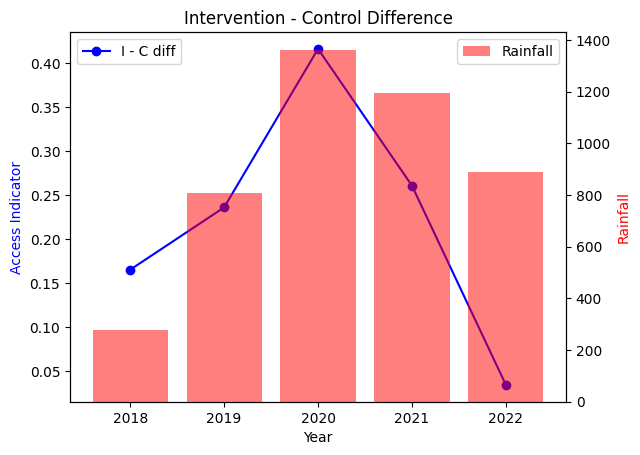

In [47]:
generate_chart('erragudi_gooty_anantapur_andhra pradesh')

In [50]:
generate_map('erragudi_gooty_anantapur_andhra pradesh', 2021)

- access indicator for some villages in some year are -999 since the LULC maps show class as background
- the ndvi (>=0.3) and sentinel2 sat image above for Dec and Jan months shows double cropping class not being accurate
  - we can compare double cropping area and ndvi area for all years and come up with a way to get the villages (I&C) that are consistently having large variation between ndvi and double crop using std dev
- another check to do is to find villages consistently having max % of others class and compare sat image and LULC

---

- chart for variation in area of natural vegetation / plantation class over the years for village

---

PRADAN:
- find out percentage of points shared by them are plantation class in latest (2022-23) LULC maps for corresponding locations
- find out when the plantation class occurs and what class was it before from the LULC maps for the given plantation points